# NICE: Non-linear Independent Components Estimation

We will apply this algorithm to the MNIST data set to generate new handwritten digits.

## Table of Contents

1. [Hyperparameters](#1st)
2. [Import libraries, define classes and functions](#2nd)
3. [Data preprocessing](#3rd)
4. [Model](#4th)
5. [Training](#5th)
6. [Nearest neighbour](#6th)
7. [References](#7th)

<div id='1st'/>

## 1. Hyperparameters

In [1]:
cfg = {
  'MODEL_SAVE_PATH': './save/models/',

  'USE_CUDA': False, #True,

  'TRAIN_BATCH_SIZE': 256,

  'TRAIN_EPOCHS': 100, # 75 initially!!

  'NUM_COUPLING_LAYERS': 4,

  'NUM_NET_LAYERS': 4,  # 6 initially # neural net layers for each coupling layer

  'NUM_HIDDEN_UNITS': 500 # 1000
}

<div id='2nd'/>

## 2. Import libraries, define classes and functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution, Uniform
import numpy as np
import os
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import sys
import matplotlib.pyplot as plt
import pylab
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The **additive coupling layer**, after deciding the partitions of the image space $I_1$ and $I_2$, basically goes as follows:
$$y_{I_1} = x_{I_1}$$
$$y_{I_2} = x_{I_2} + m(x_{I_1})$$
This makes sure that the transformation is invertible. The way this is done in the class is by using masks so that we can basically choose any convenient partition we want.

In [3]:
class CouplingLayer(nn.Module):
  """
  Implementation of the additive coupling layer from section 3.2 of the NICE
  paper.
  """

  def __init__(self, data_dim, hidden_dim, mask, num_layers=4):
    super().__init__()

    assert data_dim % 2 == 0

    self.mask = mask

    modules = [nn.Linear(data_dim, hidden_dim), nn.LeakyReLU(0.2)]
    for i in range(num_layers - 2):
      modules.append(nn.Linear(hidden_dim, hidden_dim))
      modules.append(nn.LeakyReLU(0.2))
    modules.append(nn.Linear(hidden_dim, data_dim))

    # the function m of the coupling layer is a neural net.
    self.m = nn.Sequential(*modules)

  def forward(self, x, logdet, invert=False):
    if not invert:
      x1, x2 = self.mask * x, (1. - self.mask) * x
      y1, y2 = x1, x2 + (self.m(x1) * (1. - self.mask))
      return y1 + y2, logdet

    # Inverse additive coupling layer
    y1, y2 = self.mask * x, (1. - self.mask) * x
    x1, x2 = y1, y2 - (self.m(y1) * (1. - self.mask))
    return x1 + x2, logdet

The **scaling layer** is only scaling each element of the transformation by a factor:
$$y_i = S_i x_i$$

In [4]:
class ScalingLayer(nn.Module):
  """
  Implementation of the scaling layer from section 3.3 of the NICE paper.
  """
  def __init__(self, data_dim):
    super().__init__()
    self.log_scale_vector = nn.Parameter(torch.randn(1, data_dim, requires_grad=True))

  def forward(self, x, logdet, invert=False):
    log_det_jacobian = torch.sum(self.log_scale_vector)

    if invert:
        return torch.exp(- self.log_scale_vector) * x, logdet - log_det_jacobian

    return torch.exp(self.log_scale_vector) * x, logdet + log_det_jacobian

This is basically the logistic distribution with $\sigma = 1$ and $\mu = 0$.

In [5]:
class LogisticDistribution(Distribution):
  def __init__(self):
    super().__init__()

  def log_prob(self, x):
    return -(F.softplus(x) + F.softplus(-x))

  def sample(self, size):
    if cfg['USE_CUDA']:
      z = Uniform(torch.cuda.FloatTensor([0.]), torch.cuda.FloatTensor([1.])).sample(size)
    else:
      z = Uniform(torch.FloatTensor([0.]), torch.FloatTensor([1.])).sample(size)

    return torch.log(z) - torch.log(1. - z)

<div id='3rd'/>

## 3. Data preprocessing

In [6]:
# Data preprocessing:
transform = transforms.ToTensor()

dataset = datasets.MNIST(root='./data/mnist', train=True, transform=transform, download=True)
test = datasets.MNIST(root='./data/mnist', train=False, transform=transform, download=True)

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=cfg['TRAIN_BATCH_SIZE'],
                                         shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=cfg['TRAIN_BATCH_SIZE'],
                                         shuffle=True, pin_memory=True)

<div id='4th'/>

## 4. Model

In [7]:
class NICE(nn.Module):
  def __init__(self, data_dim, num_coupling_layers=3):
    super().__init__()

    self.data_dim = data_dim
    # alternating mask orientations for consecutive coupling layers
    # The mask will be used as the partition of each additive coupling layer...
    # For each layer we change orientation :)
    masks = [self._get_mask(data_dim, orientation=(i % 2 == 0))
                                            for i in range(num_coupling_layers)]

    self.coupling_layers = nn.ModuleList([CouplingLayer(data_dim=data_dim,
                                hidden_dim=cfg['NUM_HIDDEN_UNITS'],
                                mask=masks[i], num_layers=cfg['NUM_NET_LAYERS'])
                              for i in range(num_coupling_layers)])

    self.scaling_layer = ScalingLayer(data_dim=data_dim)

    self.prior = LogisticDistribution()

  def forward(self, x, invert=False):
    if not invert:
      z, log_det_jacobian = self.f(x)
      log_likelihood = torch.sum(self.prior.log_prob(z), dim=1) + log_det_jacobian
      return z, log_likelihood

    return self.f_inverse(x)

  def f(self, x):
    z = x
    log_det_jacobian = 0
    for i, coupling_layer in enumerate(self.coupling_layers):
      z, log_det_jacobian = coupling_layer(z, log_det_jacobian)
    z, log_det_jacobian = self.scaling_layer(z, log_det_jacobian)
    return z, log_det_jacobian

  def f_inverse(self, z):
    x = z
    x, _ = self.scaling_layer(x, 0, invert=True)
    for i, coupling_layer in reversed(list(enumerate(self.coupling_layers))):
      x, _ = coupling_layer(x, 0, invert=True)
    return x

  def sample(self, num_samples):
    z = self.prior.sample([num_samples, self.data_dim]).view(num_samples, self.data_dim) # self.samples before...
    return self.f_inverse(z)

  def _get_mask(self, dim, orientation=True):
    mask = np.zeros(dim)
    mask[::2] = 1.
    if orientation:
      mask = 1. - mask     # flip mask orientation
    mask = torch.tensor(mask)
    if cfg['USE_CUDA']:
      mask = mask.cuda()
    return mask.float()

In [8]:
# Model and criterion:
model = NICE(data_dim=784, num_coupling_layers=cfg['NUM_COUPLING_LAYERS'])
if cfg['USE_CUDA']:
  device = torch.device('cuda')
  model = model.to(device)

In [9]:
# Load model
#state_dict = torch.load('save/models/59.pt')
#model.load_state_dict(state_dict)

<div id='5th'/>

## 5. Training

In [10]:
opt = optim.Adam(model.parameters())

In [11]:
# TRAINING:
testL = np.zeros(cfg['TRAIN_EPOCHS'])
trainL = np.zeros(cfg['TRAIN_EPOCHS'])

Epoch 0 completed. Log Likelihood: -1016.4630737304688
Test Log Likelihood: -916.4060668945312


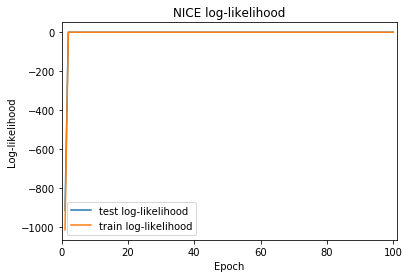

Epoch 1 completed. Log Likelihood: -823.5634155273438
Test Log Likelihood: -731.5460205078125


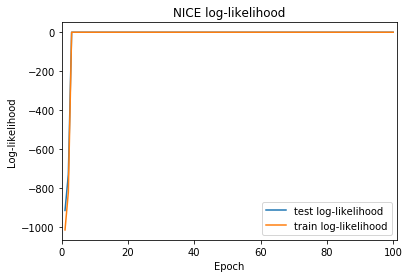

Epoch 2 completed. Log Likelihood: -640.6873779296875
Test Log Likelihood: -550.3209838867188


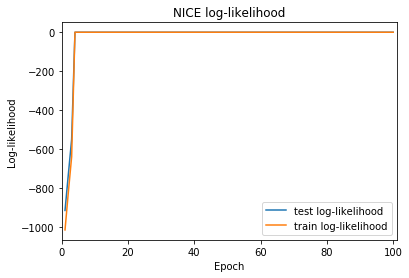

Epoch 3 completed. Log Likelihood: -461.26531982421875
Test Log Likelihood: -372.8648376464844


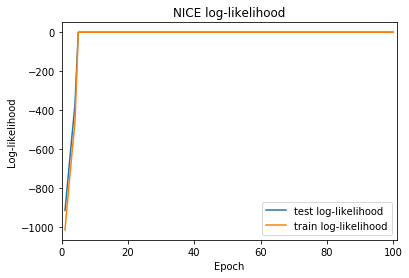

Epoch 4 completed. Log Likelihood: -285.52490234375
Test Log Likelihood: -200.30862426757812


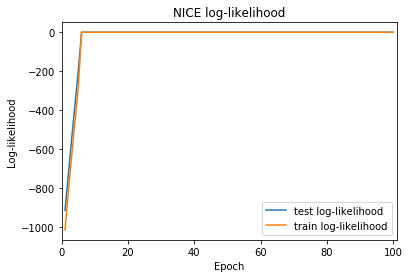

Epoch 5 completed. Log Likelihood: -114.19441223144531
Test Log Likelihood: -32.007633209228516


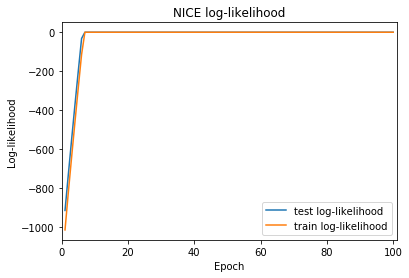

Epoch 6 completed. Log Likelihood: 51.48127365112305
Test Log Likelihood: 130.9298553466797


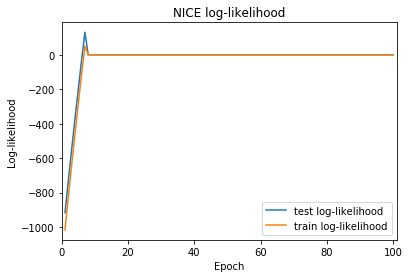

Epoch 7 completed. Log Likelihood: 210.72711181640625
Test Log Likelihood: 284.7812805175781


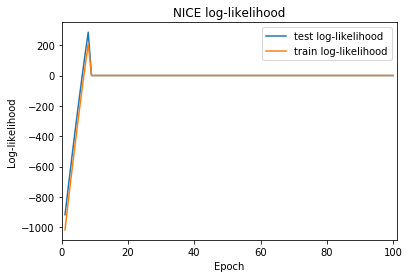

Epoch 8 completed. Log Likelihood: 361.5053405761719
Test Log Likelihood: 430.1980895996094


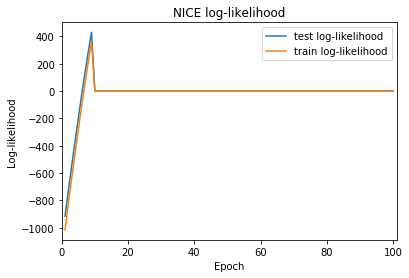

Epoch 9 completed. Log Likelihood: 504.6275939941406
Test Log Likelihood: 567.8444213867188


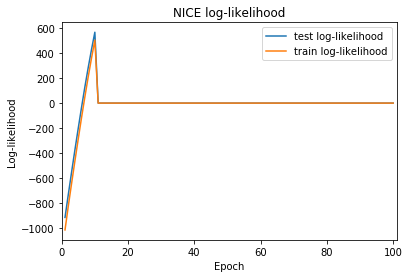

Epoch 10 completed. Log Likelihood: 637.9678955078125
Test Log Likelihood: 694.0465087890625


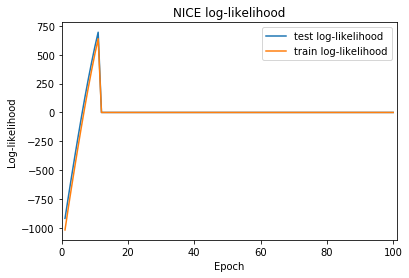

Epoch 11 completed. Log Likelihood: 762.4356079101562
Test Log Likelihood: 811.968994140625


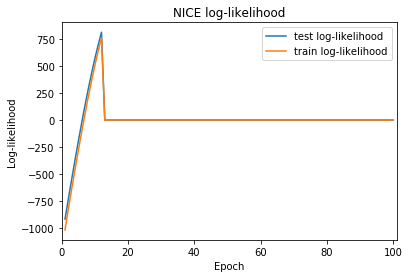

Epoch 12 completed. Log Likelihood: 877.7154541015625
Test Log Likelihood: 919.7325439453125


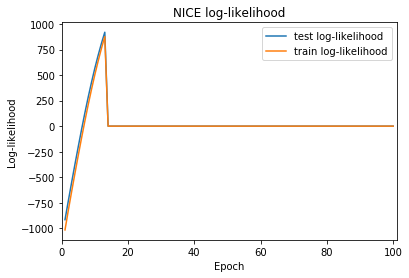

Epoch 13 completed. Log Likelihood: 984.1236572265625
Test Log Likelihood: 1017.7120971679688


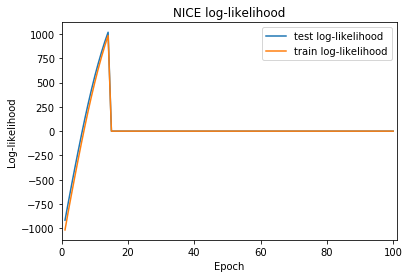

Epoch 14 completed. Log Likelihood: 1082.62255859375
Test Log Likelihood: 1112.081298828125


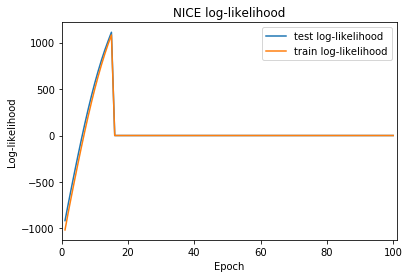

Epoch 15 completed. Log Likelihood: 1173.505615234375
Test Log Likelihood: 1199.00341796875


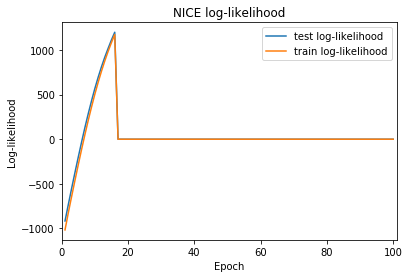

Epoch 16 completed. Log Likelihood: 1256.2933349609375
Test Log Likelihood: 1275.080810546875


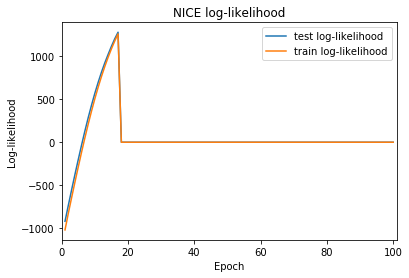

Epoch 17 completed. Log Likelihood: 1331.27783203125
Test Log Likelihood: 1341.4503173828125


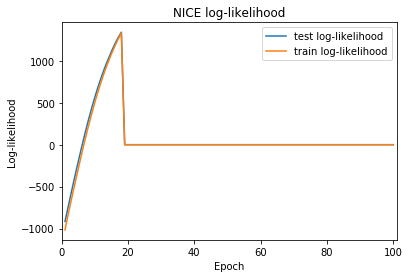

Epoch 18 completed. Log Likelihood: 1400.4722900390625
Test Log Likelihood: 1410.7244873046875


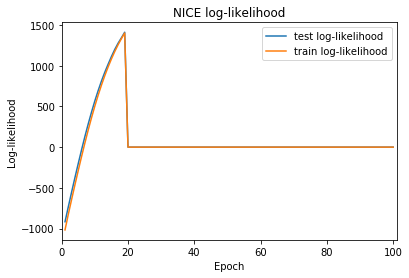

Epoch 19 completed. Log Likelihood: 1462.7353515625
Test Log Likelihood: 1460.4053955078125


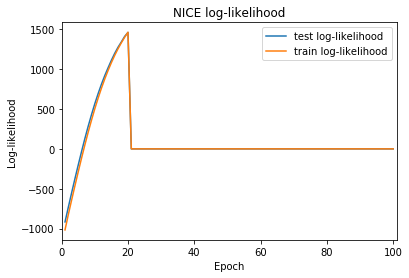

Epoch 20 completed. Log Likelihood: 1518.44091796875
Test Log Likelihood: 1512.02880859375


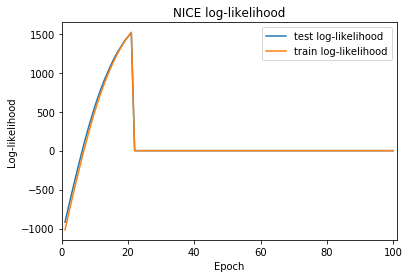

Epoch 21 completed. Log Likelihood: 1568.599609375
Test Log Likelihood: 1560.9876708984375


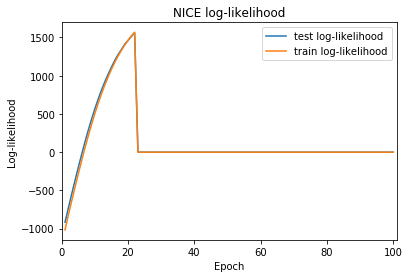

Epoch 22 completed. Log Likelihood: 1612.6639404296875
Test Log Likelihood: 1602.9097900390625


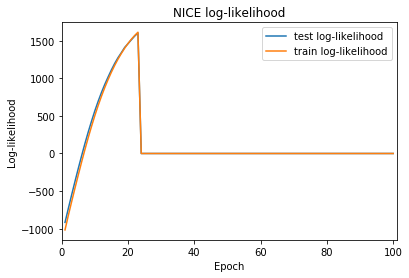

Epoch 23 completed. Log Likelihood: 1652.468994140625
Test Log Likelihood: 1629.84765625


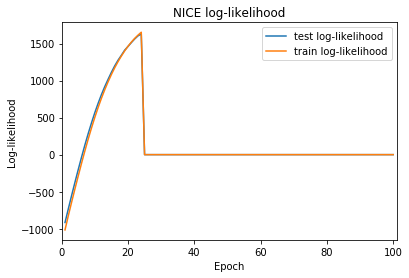

Epoch 24 completed. Log Likelihood: 1685.3372802734375
Test Log Likelihood: 1655.898193359375


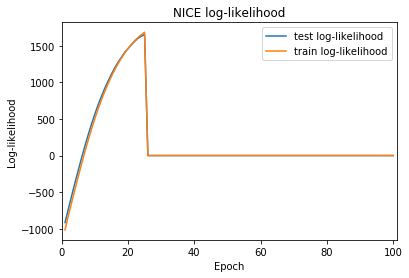

Epoch 25 completed. Log Likelihood: 1714.476318359375
Test Log Likelihood: 1687.7913818359375


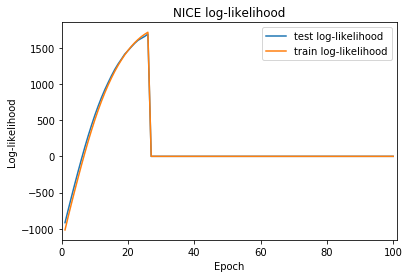

Epoch 26 completed. Log Likelihood: 1739.698974609375
Test Log Likelihood: 1701.261474609375


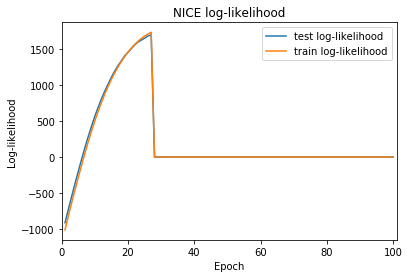

Epoch 27 completed. Log Likelihood: 1763.5140380859375
Test Log Likelihood: 1718.3382568359375


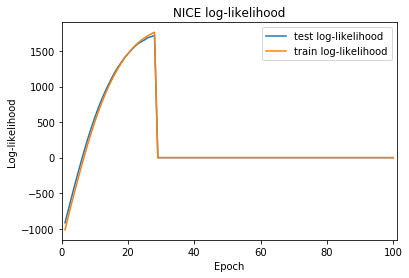

Epoch 28 completed. Log Likelihood: 1782.3734130859375
Test Log Likelihood: 1732.1156005859375


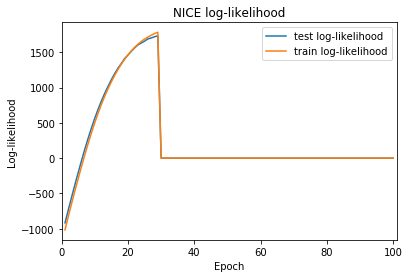

Epoch 29 completed. Log Likelihood: 1800.716796875
Test Log Likelihood: 1734.502197265625


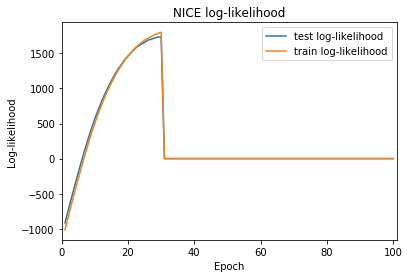

Epoch 30 completed. Log Likelihood: 1815.755859375
Test Log Likelihood: 1756.4957275390625


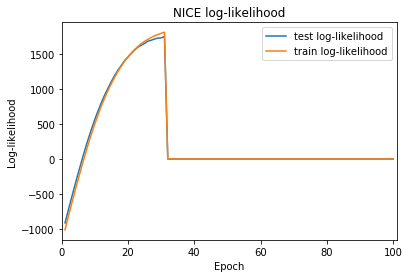

Epoch 31 completed. Log Likelihood: 1830.8258056640625
Test Log Likelihood: 1766.1998291015625


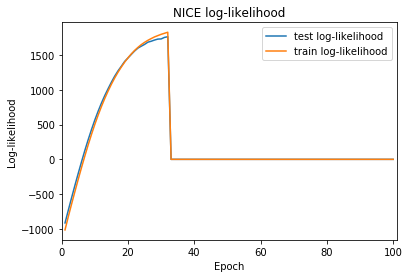

Epoch 32 completed. Log Likelihood: 1844.1873779296875
Test Log Likelihood: 1765.3043212890625


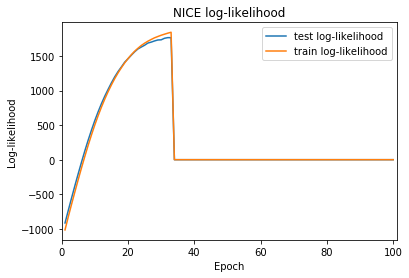

Epoch 33 completed. Log Likelihood: 1856.43359375
Test Log Likelihood: 1779.0064697265625


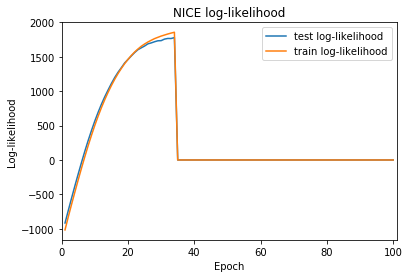

Epoch 34 completed. Log Likelihood: 1865.9962158203125
Test Log Likelihood: 1781.9075927734375


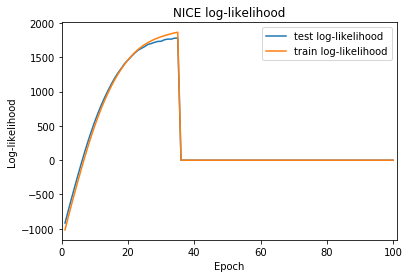

Epoch 35 completed. Log Likelihood: 1875.28173828125
Test Log Likelihood: 1782.720458984375


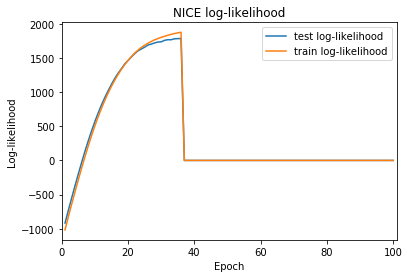

Epoch 36 completed. Log Likelihood: 1884.03662109375
Test Log Likelihood: 1795.4195556640625


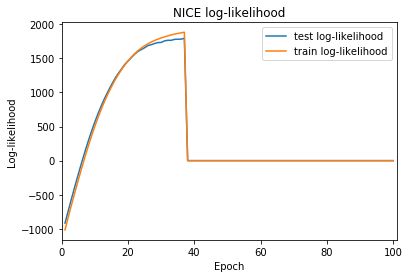

Epoch 37 completed. Log Likelihood: 1893.288818359375
Test Log Likelihood: 1798.3521728515625


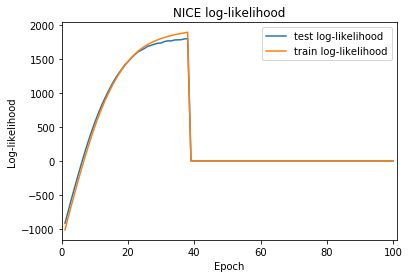

Epoch 38 completed. Log Likelihood: 1900.649169921875
Test Log Likelihood: 1789.9342041015625


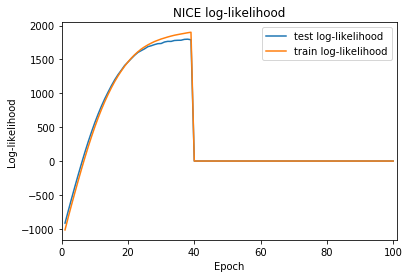

Epoch 39 completed. Log Likelihood: 1906.3201904296875
Test Log Likelihood: 1823.951416015625


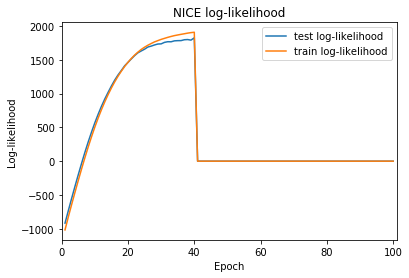

Epoch 40 completed. Log Likelihood: 1914.312744140625
Test Log Likelihood: 1802.832275390625


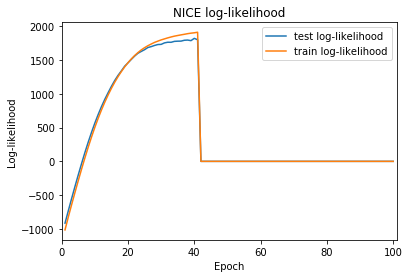

Epoch 41 completed. Log Likelihood: 1918.7532958984375
Test Log Likelihood: 1824.328369140625


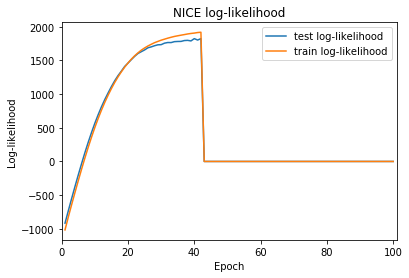

Epoch 42 completed. Log Likelihood: 1927.0311279296875
Test Log Likelihood: 1818.4652099609375


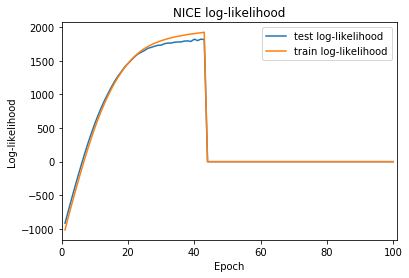

Epoch 43 completed. Log Likelihood: 1930.8172607421875
Test Log Likelihood: 1827.5103759765625


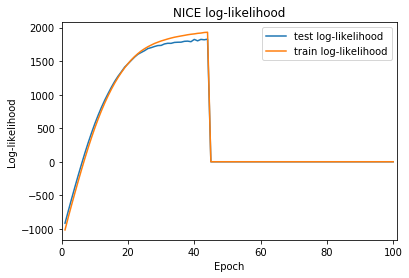

Epoch 44 completed. Log Likelihood: 1936.635986328125
Test Log Likelihood: 1813.5787353515625


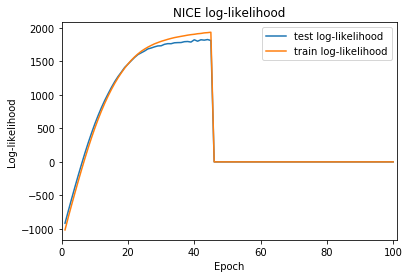

Epoch 45 completed. Log Likelihood: 1939.310791015625
Test Log Likelihood: 1828.568603515625


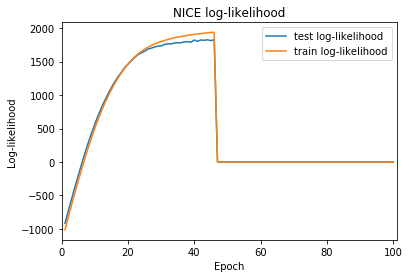

Epoch 46 completed. Log Likelihood: 1946.91357421875
Test Log Likelihood: 1817.9146728515625


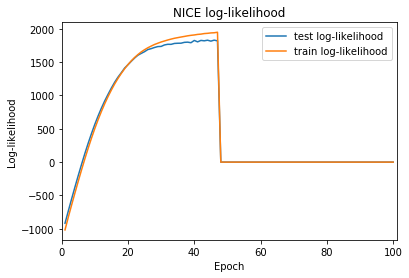

Epoch 47 completed. Log Likelihood: 1948.693603515625
Test Log Likelihood: 1829.6881103515625


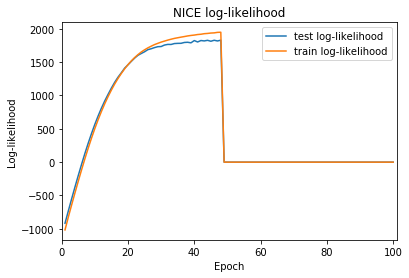

Epoch 48 completed. Log Likelihood: 1951.988525390625
Test Log Likelihood: 1819.2330322265625


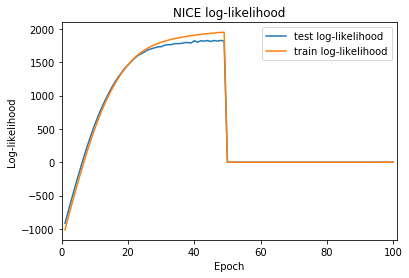

Epoch 49 completed. Log Likelihood: 1955.69091796875
Test Log Likelihood: 1832.5152587890625


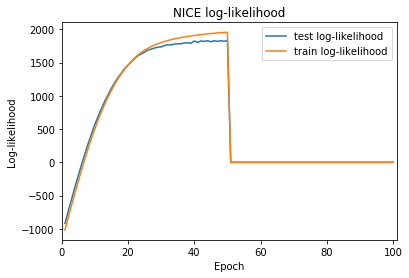

Epoch 50 completed. Log Likelihood: 1957.8973388671875
Test Log Likelihood: 1838.6068115234375


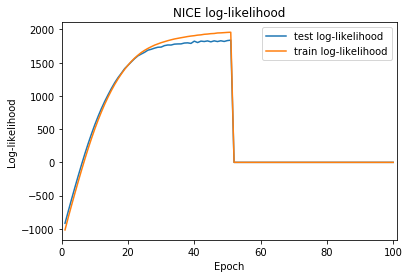

Epoch 51 completed. Log Likelihood: 1963.3782958984375
Test Log Likelihood: 1832.028076171875


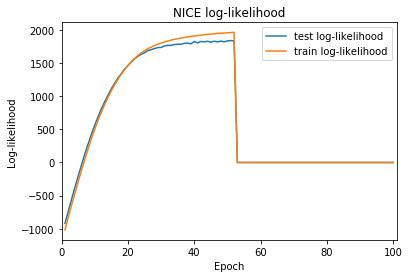

Epoch 52 completed. Log Likelihood: 1966.1295166015625
Test Log Likelihood: 1844.181640625


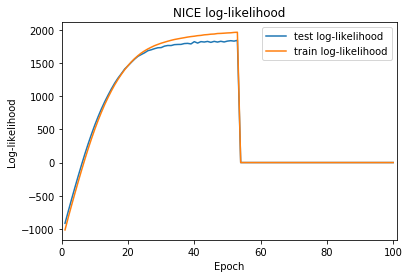

Epoch 53 completed. Log Likelihood: 1968.0858154296875
Test Log Likelihood: 1829.223388671875


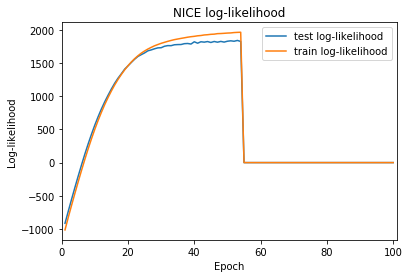

Epoch 54 completed. Log Likelihood: 1971.99462890625
Test Log Likelihood: 1848.4359130859375


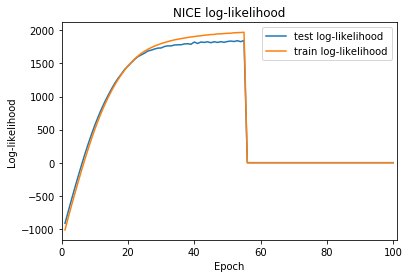

Epoch 55 completed. Log Likelihood: 1977.1329345703125
Test Log Likelihood: 1850.015869140625


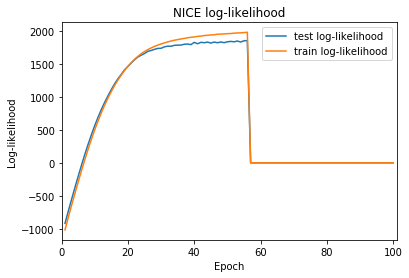

Epoch 56 completed. Log Likelihood: 1978.3768310546875
Test Log Likelihood: 1854.962646484375


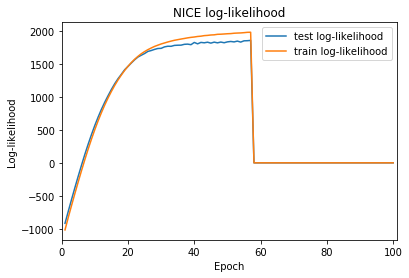

Epoch 57 completed. Log Likelihood: 1980.222900390625
Test Log Likelihood: 1847.9066162109375


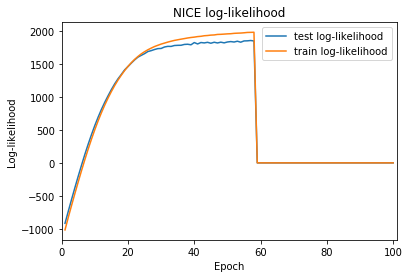

Epoch 58 completed. Log Likelihood: 1983.270263671875
Test Log Likelihood: 1851.894775390625


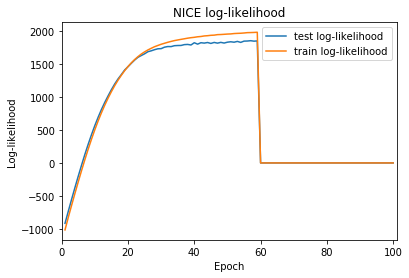

Epoch 59 completed. Log Likelihood: 1986.932373046875
Test Log Likelihood: 1845.250244140625


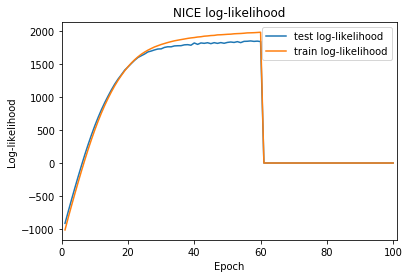

Epoch 60 completed. Log Likelihood: 1988.181884765625
Test Log Likelihood: 1861.266845703125


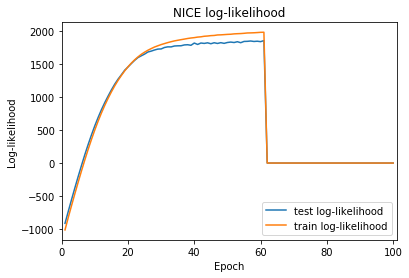

Epoch 61 completed. Log Likelihood: 1990.628173828125
Test Log Likelihood: 1845.6676025390625


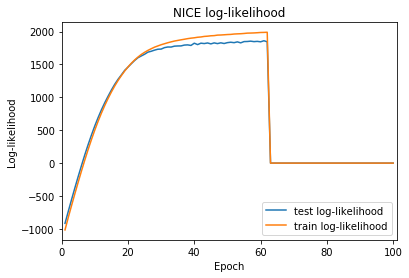

Epoch 62 completed. Log Likelihood: 1994.3800048828125
Test Log Likelihood: 1850.3275146484375


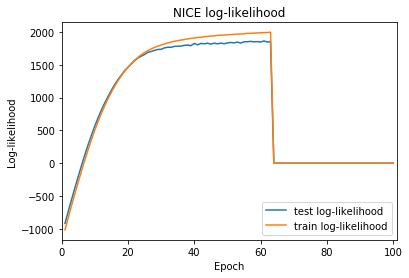

Epoch 63 completed. Log Likelihood: 1995.7650146484375
Test Log Likelihood: 1855.877197265625


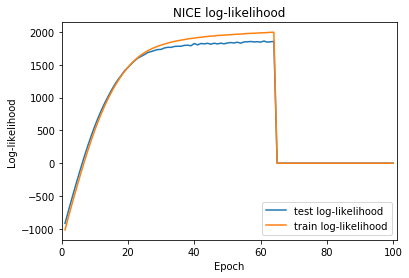

Epoch 64 completed. Log Likelihood: 1996.696533203125
Test Log Likelihood: 1876.381103515625


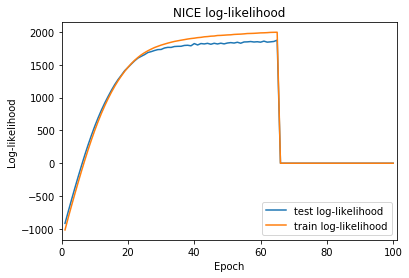

Epoch 65 completed. Log Likelihood: 1999.7457275390625
Test Log Likelihood: 1863.693115234375


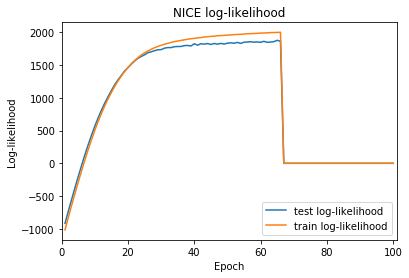

Epoch 66 completed. Log Likelihood: 2001.8197021484375
Test Log Likelihood: 1861.7825927734375


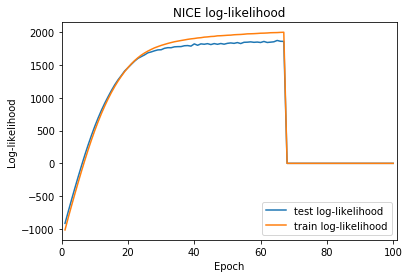

Epoch 67 completed. Log Likelihood: 2004.6278076171875
Test Log Likelihood: 1857.226318359375


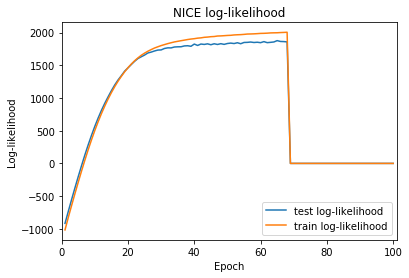

Epoch 68 completed. Log Likelihood: 2006.145751953125
Test Log Likelihood: 1858.578857421875


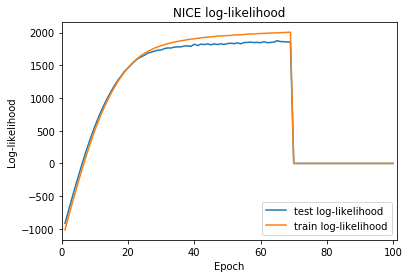

Epoch 69 completed. Log Likelihood: 2008.653076171875
Test Log Likelihood: 1866.360595703125


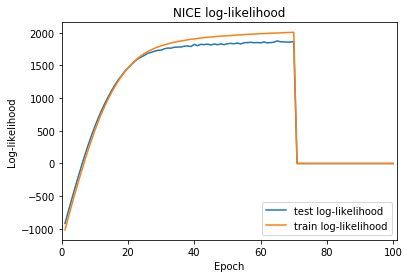

Epoch 70 completed. Log Likelihood: 2010.272705078125
Test Log Likelihood: 1869.7412109375


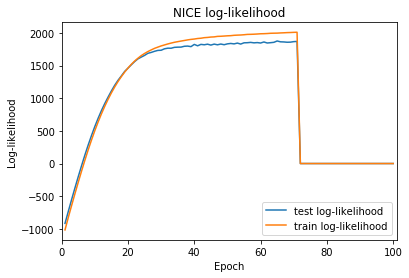

Epoch 71 completed. Log Likelihood: 2012.093505859375
Test Log Likelihood: 1875.651123046875


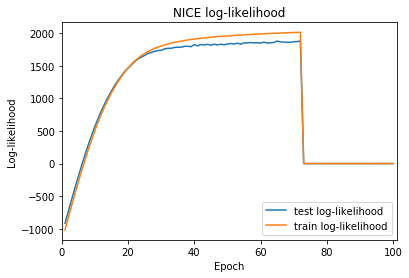

Epoch 72 completed. Log Likelihood: 2013.3551025390625
Test Log Likelihood: 1878.8394775390625


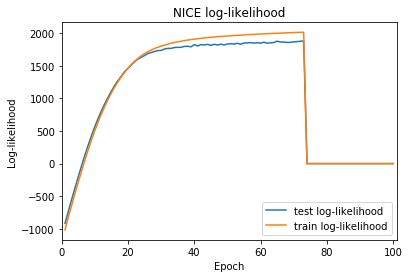

Epoch 73 completed. Log Likelihood: 2015.7305908203125
Test Log Likelihood: 1875.416259765625


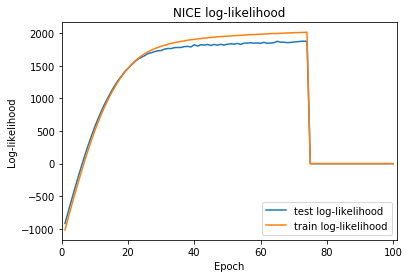

Epoch 74 completed. Log Likelihood: 2016.5382080078125
Test Log Likelihood: 1882.3883056640625


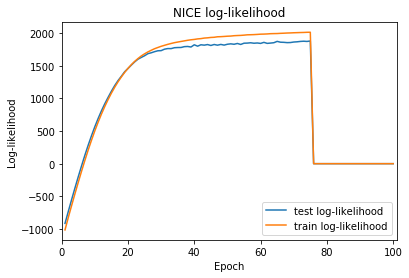

Epoch 75 completed. Log Likelihood: 2017.899169921875
Test Log Likelihood: 1885.3675537109375


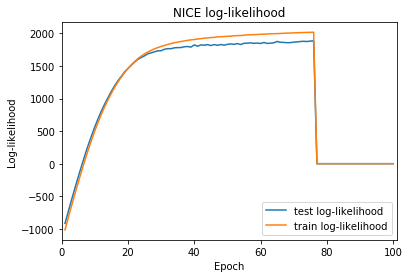

Epoch 76 completed. Log Likelihood: 2020.510009765625
Test Log Likelihood: 1868.186279296875


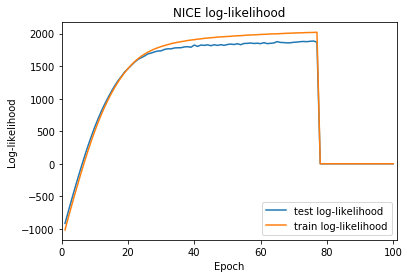

Epoch 77 completed. Log Likelihood: 2022.90380859375
Test Log Likelihood: 1877.628173828125


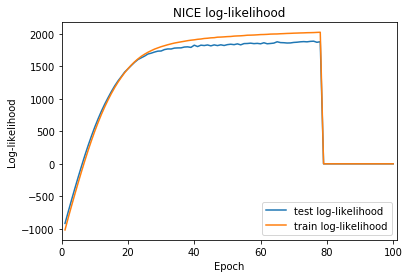

Epoch 78 completed. Log Likelihood: 2023.4205322265625
Test Log Likelihood: 1873.906494140625


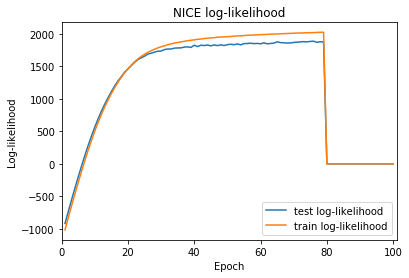

Epoch 79 completed. Log Likelihood: 2024.4388427734375
Test Log Likelihood: 1867.905029296875


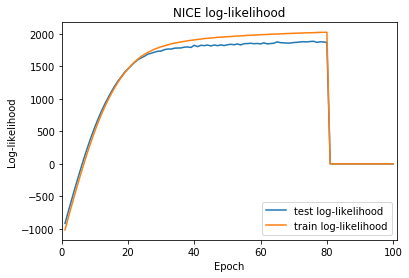

Epoch 80 completed. Log Likelihood: 2027.4305419921875
Test Log Likelihood: 1894.318115234375


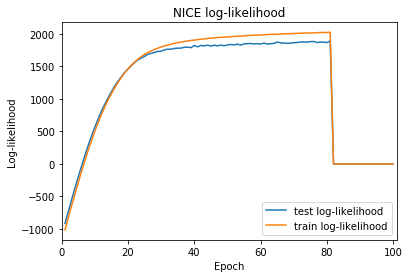

Epoch 81 completed. Log Likelihood: 2029.104248046875
Test Log Likelihood: 1882.542236328125


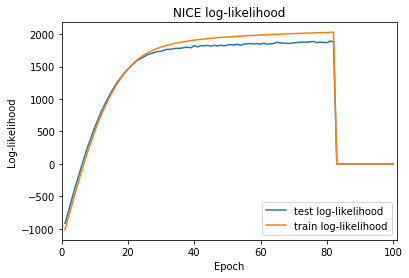

Epoch 82 completed. Log Likelihood: 2030.9169921875
Test Log Likelihood: 1867.4788818359375


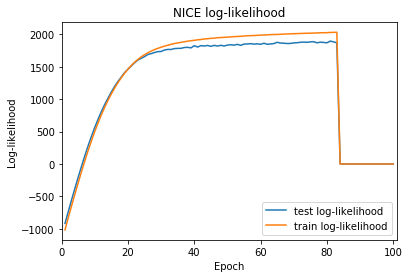

Epoch 83 completed. Log Likelihood: 2029.750244140625
Test Log Likelihood: 1885.408935546875


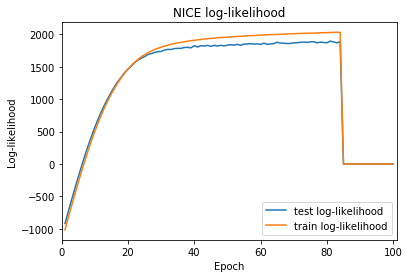

Epoch 84 completed. Log Likelihood: 2031.778076171875
Test Log Likelihood: 1887.761474609375


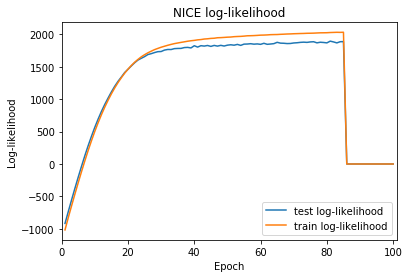

Epoch 85 completed. Log Likelihood: 2033.018310546875
Test Log Likelihood: 1901.4010009765625


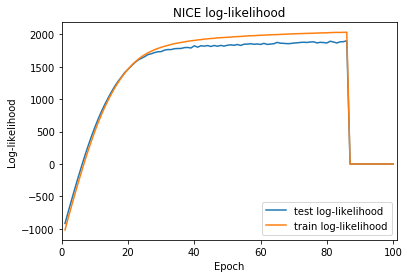

Epoch 86 completed. Log Likelihood: 2035.835693359375
Test Log Likelihood: 1887.9339599609375


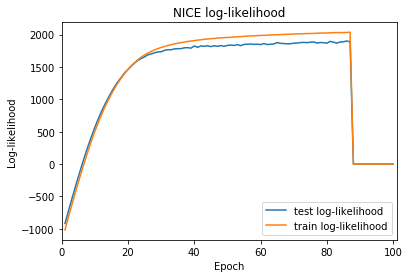

Epoch 87 completed. Log Likelihood: 2037.723388671875
Test Log Likelihood: 1890.4437255859375


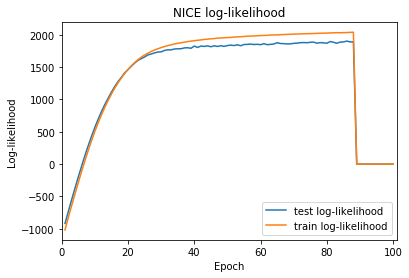

Epoch 88 completed. Log Likelihood: 2036.675048828125
Test Log Likelihood: 1893.5986328125


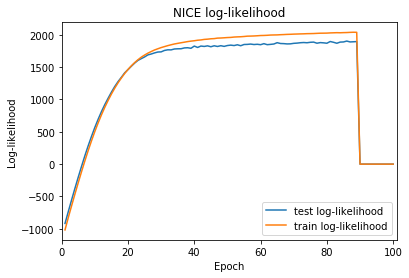

Epoch 89 completed. Log Likelihood: 2037.977783203125
Test Log Likelihood: 1882.3411865234375


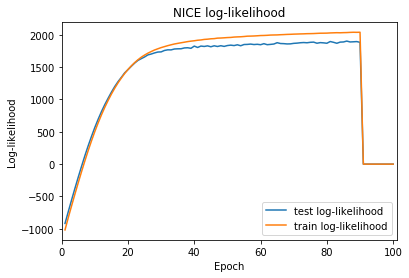

Epoch 90 completed. Log Likelihood: 2040.2615966796875
Test Log Likelihood: 1872.4609375


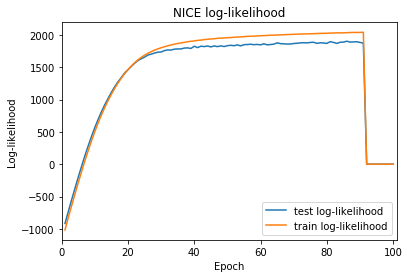

Epoch 91 completed. Log Likelihood: 2040.5020751953125
Test Log Likelihood: 1891.2916259765625


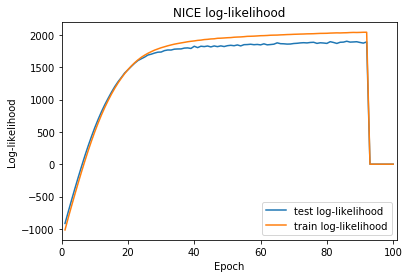

Epoch 92 completed. Log Likelihood: 2041.64697265625
Test Log Likelihood: 1871.508056640625


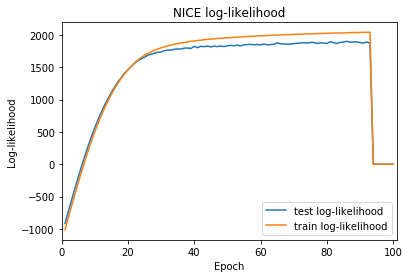

Epoch 93 completed. Log Likelihood: 2042.9296875
Test Log Likelihood: 1896.6575927734375


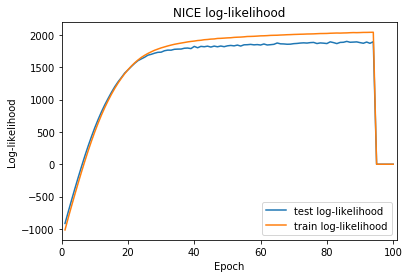

Epoch 94 completed. Log Likelihood: 2043.380126953125
Test Log Likelihood: 1894.8837890625


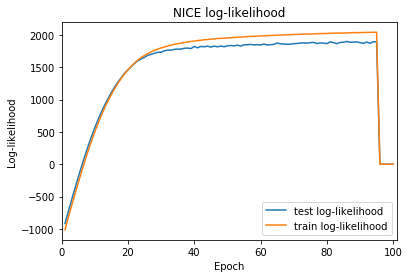

Epoch 95 completed. Log Likelihood: 2045.998291015625
Test Log Likelihood: 1909.2183837890625


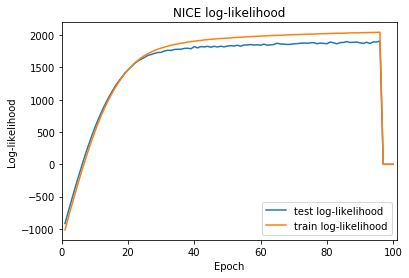

Epoch 96 completed. Log Likelihood: 2047.2196044921875
Test Log Likelihood: 1882.732666015625


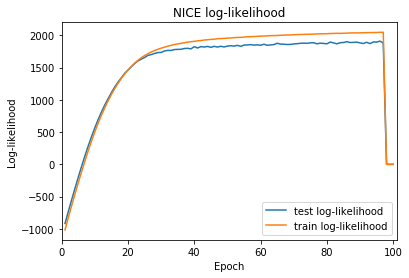

Epoch 97 completed. Log Likelihood: 2045.77880859375
Test Log Likelihood: 1879.4505615234375


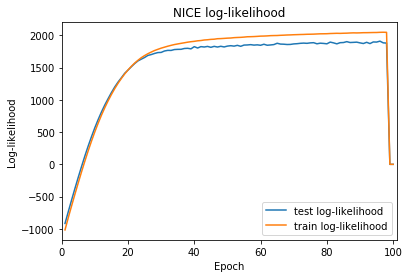

Epoch 98 completed. Log Likelihood: 2048.25537109375
Test Log Likelihood: 1894.568115234375


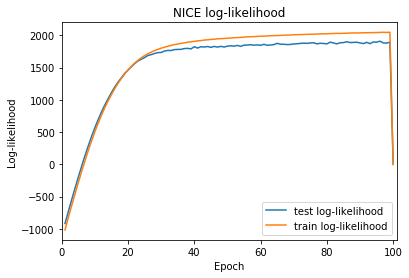

Epoch 99 completed. Log Likelihood: 2051.61572265625
Test Log Likelihood: 1881.8734130859375


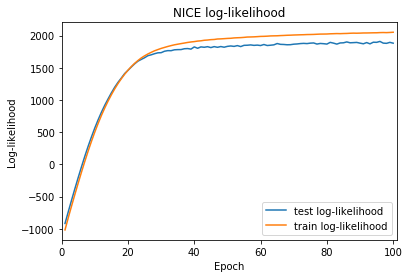

In [12]:
for epoch in range(cfg['TRAIN_EPOCHS']):
      mean_likelihood = 0.0
      num_minibatches = 0

      model.train()

      # TRAINING
      for batch_id, (x, _) in enumerate(dataloader):
          x = x.view(-1, 784) + torch.rand(784) / 256. # Uniform noise between 0 and 1/256 at most!
          if cfg['USE_CUDA']:
            x = x.cuda()

          x = torch.clamp(x, 0, 1) # Make sure values between 0 and 1.

          z, likelihood = model(x)
          loss = -torch.mean(likelihood)   # NLL

          loss.backward()
          opt.step()
          model.zero_grad()

          mean_likelihood -= loss
          num_minibatches += 1

          #print(mean_likelihood / num_minibatches)
          #print(batch_id)

      mean_likelihood /= num_minibatches
      trainL[epoch] = mean_likelihood
      print('Epoch {} completed. Log Likelihood: {}'.format(epoch, mean_likelihood))

      # TEST EVALUATION
      ml = 0
      num_minibatches = 0
      for batch_id, (x, _) in enumerate(testloader):
          x = x.view(-1, 784)
          z, likelihood = model(x)
          l = -torch.mean(likelihood)

          ml -= l
          num_minibatches += 1

      ml /= num_minibatches
      testL[epoch] = ml
      print('Test Log Likelihood: {}'.format(ml))

      # OTHERS  
      plt.figure()
      pylab.xlim(0, cfg['TRAIN_EPOCHS'] + 1)
      plt.plot(range(1, cfg['TRAIN_EPOCHS'] + 1), testL, label='test log-likelihood')
      plt.plot(range(1, cfg['TRAIN_EPOCHS'] + 1), trainL, label='train log-likelihood')
      plt.legend()
      plt.title("NICE log-likelihood")
      plt.xlabel("Epoch")
      plt.ylabel("Log-likelihood")
      plt.savefig(os.path.join('save/values_graphs', 'loss.pdf'))
      plt.show()

      if (epoch+1) % 10 == 0:
        save_path = os.path.join(cfg['MODEL_SAVE_PATH'], '{}.pt'.format(epoch+1))
        torch.save(model.state_dict(), save_path)

        # SOME SAMPLING:
        model.train(False)

        fake_images = model.sample(64).round() # round to 0, 1
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
        sample_dir = 'samples'
        save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

<div id='6th'/>

## 6. Nearest Neighbours

In [21]:
NN = True

In [ ]:
# NEAREST NEIGHBOURS:
# Images 28x28, search the closest one.
# function(generated_image) --> closest training_image
if NN == True:
  aux_data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                batch_size=1,
                                                shuffle=False)

  def nearest_gt(generated_image):
      min_d = 0
      closest = False
      for i, (image, _) in enumerate(aux_data_loader):
          image = image.view(1, 28, 28).round() # all distances in binary...
          d = torch.dist(generated_image,image) # must be torch tensors (1,28,28)
          if i == 0 or d < min_d:
              min_d = d
              closest = image

      return closest

  fake_images = model.sample(24).round() # round to 0, 1
  fake_images = fake_images.view(24, 1, 28, 28)
  save_image(fake_images, './samples/f24.png')
  NN = torch.zeros(24, 1, 28, 28)
  for i in range(0,24):
        NN[i] = nearest_gt(fake_images[i])
        print(i)
  save_image(NN.data, './samples/NN24.png')

<div id='7th'/>

## 7. References

[1] https://github.com/DakshIdnani/pytorch-nice